In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

from keras.models import Model, Sequential

2023-06-23 12:29:01.428471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_csv("../0.data-download/data/CRISPR_gene_dictionary.tsv", delimiter='\t')
gene_list_passed_qc = gene_dict_df.query("qc_pass").dependency_column.tolist()

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list_passed_qc, axis=1)
subset_test_df = test_df.filter(gene_list_passed_qc, axis=1)

In [6]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [7]:
# load the latent dimension dataframe

latent_df = pd.read_csv("../2.train-VAE/results/latent_df.csv")

print(latent_df.shape)

latent_df.head(5)

(912, 57)


,ModelID,0,1,2,3,4,5,6,7,8,...,46,47,48,49,50,51,52,53,54,55
0,ACH-001549,0.641828,2.255752,0.576668,-0.298168,0.784063,1.417404,1.015673,1.217430,0.696243,...,-0.420182,0.285047,0.122526,-0.465228,-1.232091,2.019001,-0.656772,0.928948,-0.049118,0.971279
1,ACH-001992,1.632426,-0.214917,0.720797,1.184558,-0.456258,-0.020685,0.078458,1.447003,-0.891646,...,1.613086,0.867021,1.855364,1.396982,-0.343896,0.787118,-1.283468,0.792897,-1.442803,1.983561
2,ACH-000035,0.979069,0.280593,-0.386872,1.442345,-0.507138,0.032205,1.316004,-0.628803,-1.305066,...,0.389728,0.009500,2.060703,-0.252914,1.239301,-0.640129,0.721773,-0.396399,0.601583,0.154491
3,ACH-000911,-1.096082,-0.138509,0.793402,0.471544,0.505639,-0.863082,1.078274,0.602074,1.284546,...,0.594805,-1.081738,1.628239,0.108383,0.467460,-0.080298,-0.766951,0.951760,-1.124195,-0.422572
4,ACH-000259,-1.029162,0.433893,1.441033,-0.415763,-0.601139,0.215967,-0.880476,1.124915,-1.591494,...,1.110953,-0.999373,-0.476490,-0.433291,0.761746,2.948964,-0.437494,-0.517973,0.754666,0.462690


In [8]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list_passed_qc, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001549,Adult,Male,train
1,ACH-001992,Adult,Male,train
2,ACH-000035,Adult,Male,train
3,ACH-000911,Adult,Male,train
4,ACH-000259,Pediatric,Female,train
...,...,...,...,...
907,ACH-000858,Adult,Male,test
908,ACH-000514,Adult,Male,test
909,ACH-000258,Adult,Female,test
910,ACH-002446,Adult,Male,test


In [9]:
AgeCategory = metadata.pop("AgeCategory")
Sex = metadata.pop("Sex")
train_test = metadata.pop("train_or_test")

/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


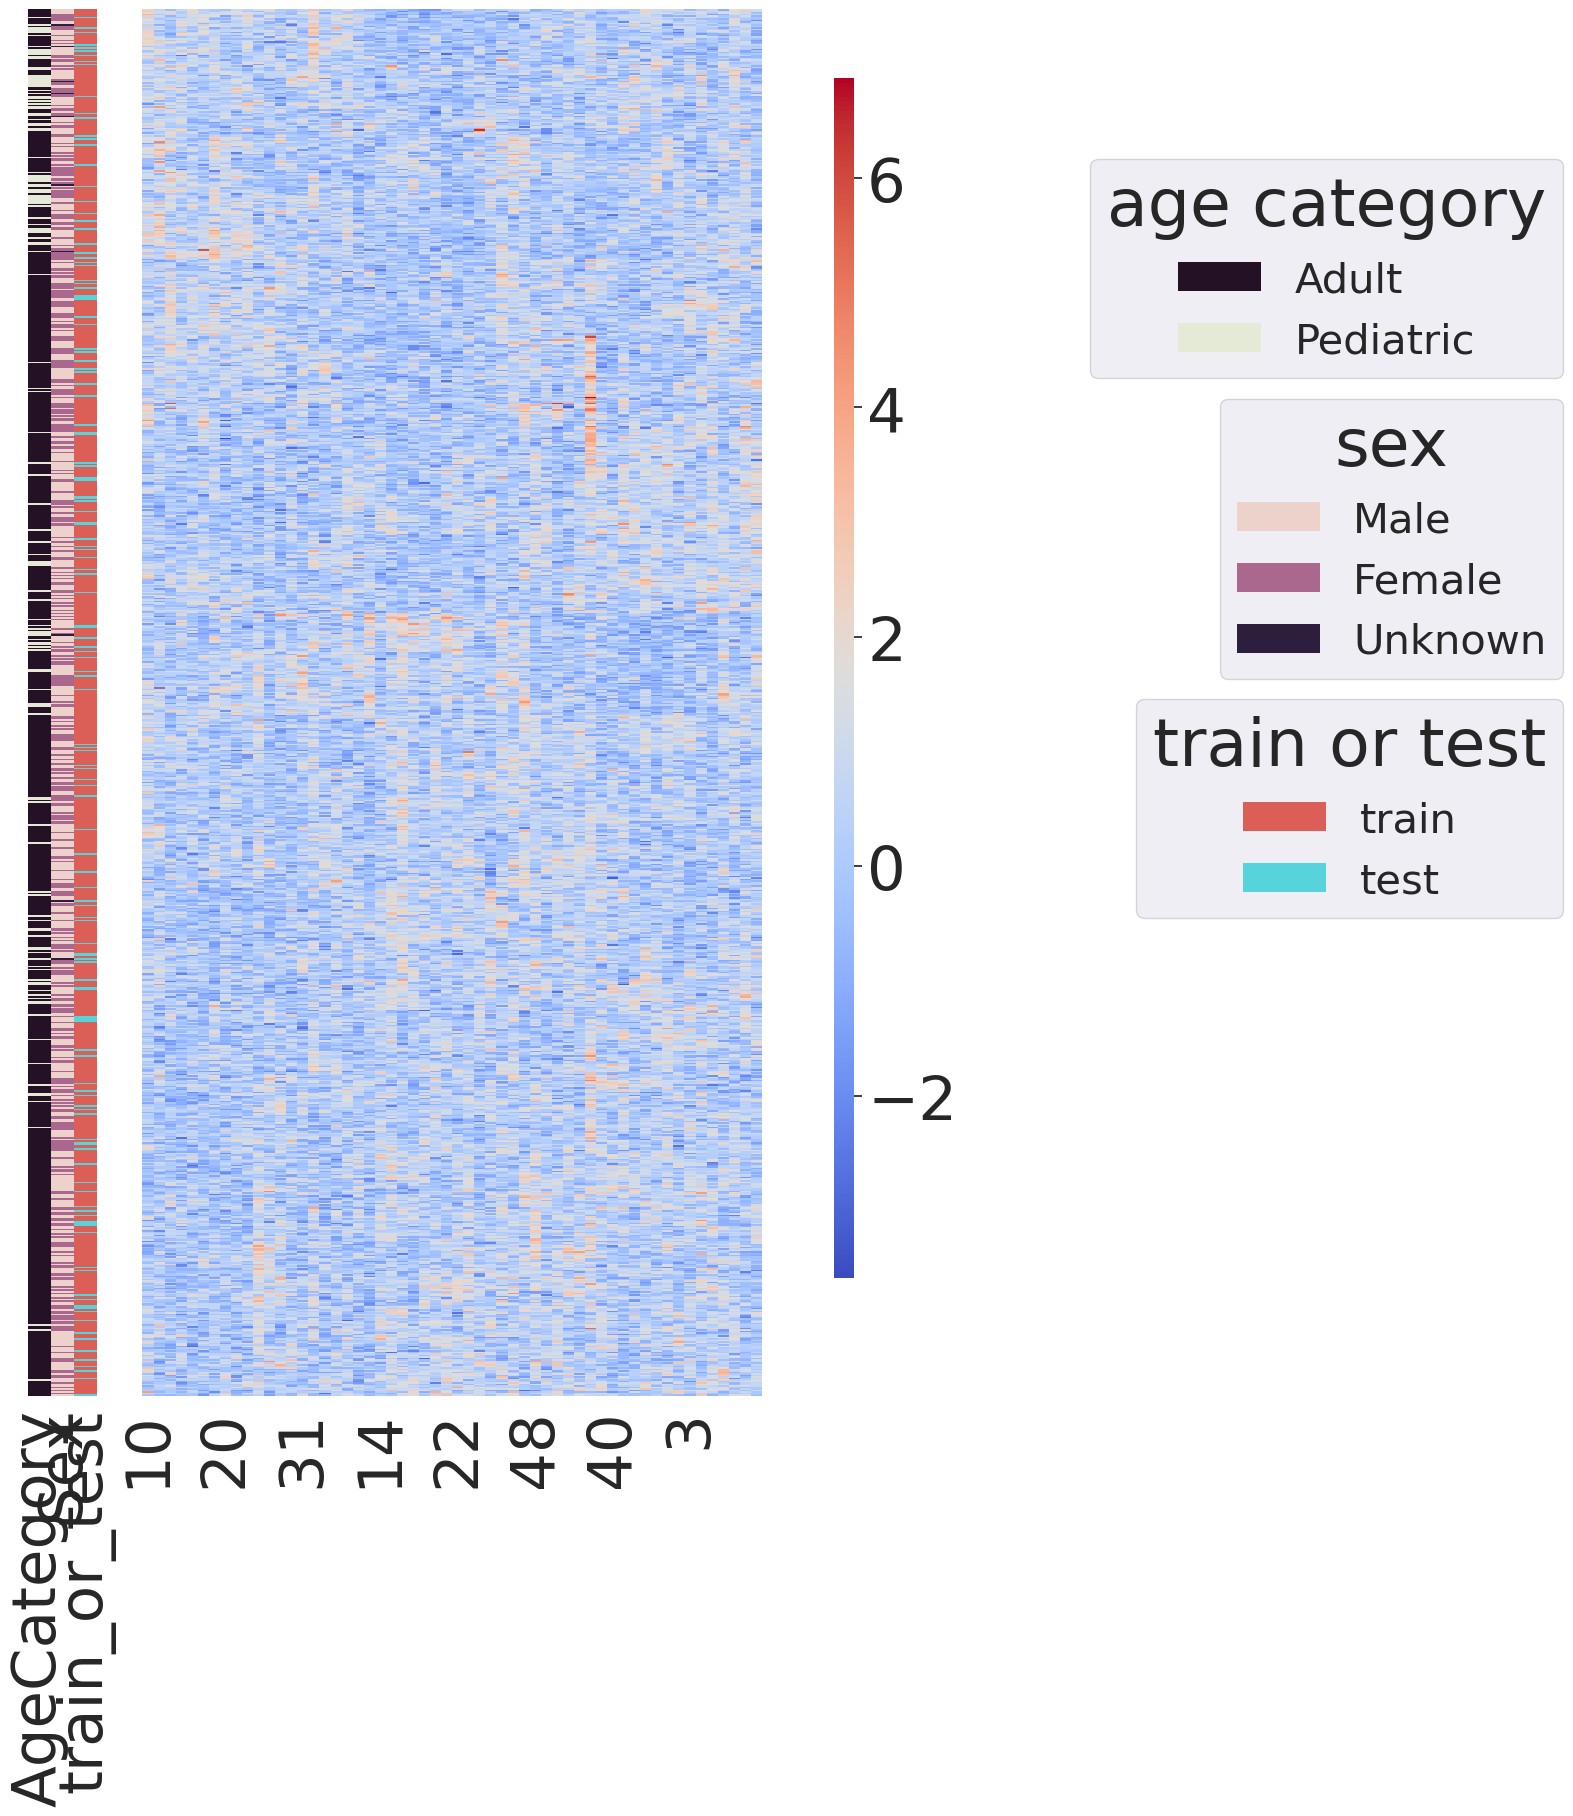

In [10]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    AgeCategory.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(Sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(AgeCategory.unique(), lut_pal))
put = dict(zip(Sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = AgeCategory.map(lut)
row_colors2 = Sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)


xx = []
for label in AgeCategory.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    AgeCategory.unique(),
    loc="upper right",
    title="age category",
    ncol=1,
    bbox_to_anchor=(1.75, 0.87),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)


yy = []
for label in Sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    Sex.unique(),
    loc="upper right",
    title="sex",
    ncol=1,
    bbox_to_anchor=(1.75, 0.75),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="upper right",
    title="train or test",
    ncol=1,
    bbox_to_anchor=(1.75, 0.6),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [11]:
# load the weights dataframe

gene_weights_df = pd.read_csv("../2.train-VAE/results/weight_matrix_encoder.csv")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-0.091149,-0.044336,-0.001164,-0.037848,0.047344,0.001991,-0.000425,-0.036371,0.041469,0.022506,...,-0.039370,0.074685,-0.076645,0.066460,-0.015115,0.039723,0.054191,0.011207,0.001318,-0.068258
1,-0.017030,0.048581,0.056772,-0.001898,0.035648,0.021300,0.030531,0.012215,-0.019249,0.032476,...,-0.023777,0.047925,0.058790,-0.016032,-0.083656,0.062707,0.067716,0.005043,-0.073420,-0.039103
2,-0.039453,0.018107,-0.022514,0.052101,0.019628,-0.051332,-0.083455,-0.002061,-0.009793,-0.062815,...,0.002679,0.026534,0.050352,0.000896,-0.018615,-0.055388,-0.034207,0.089190,-0.027525,0.043509
3,-0.046879,-0.030311,-0.053646,0.018475,0.064843,-0.021673,-0.013186,-0.066008,-0.034474,-0.022253,...,-0.016705,0.076802,0.030123,-0.029903,-0.012807,-0.052552,-0.037671,0.065382,-0.034419,0.025500
4,-0.010881,0.082702,-0.081489,0.002027,-0.003736,-0.046454,-0.001526,0.056241,-0.030425,0.002893,...,0.003135,-0.063538,-0.002247,-0.038125,0.001084,-0.060792,-0.016287,-0.027383,0.031234,-0.084249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,0.030137,-0.057799,0.040892,-0.018095,-0.046179,0.010952,0.047902,0.013384,-0.079689,-0.032569,...,-0.043391,0.037274,0.048925,0.020662,-0.072755,0.037439,0.001716,0.021661,-0.028837,-0.007683
2728,-0.028307,-0.049452,-0.050467,-0.007832,0.005744,0.014164,-0.059339,-0.044840,-0.087206,-0.040704,...,-0.058598,-0.074476,0.004918,-0.042746,0.065849,-0.034233,-0.066042,0.062822,-0.090805,-0.116382
2729,-0.047968,0.013444,0.009947,-0.037242,0.000693,-0.124306,-0.036641,-0.010858,-0.030734,-0.031973,...,0.009032,-0.037074,0.003982,-0.022172,0.010436,-0.031392,0.063189,0.007097,-0.085796,-0.013385
2730,-0.045941,-0.025676,-0.085146,0.038020,-0.019821,-0.023524,-0.054617,-0.074985,-0.000067,-0.072945,...,-0.063037,-0.109853,-0.034519,-0.019802,-0.037204,-0.083122,-0.013420,-0.081653,0.044528,-0.019205


/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ecohen/anaconda3/envs/gene_dependency_representations/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


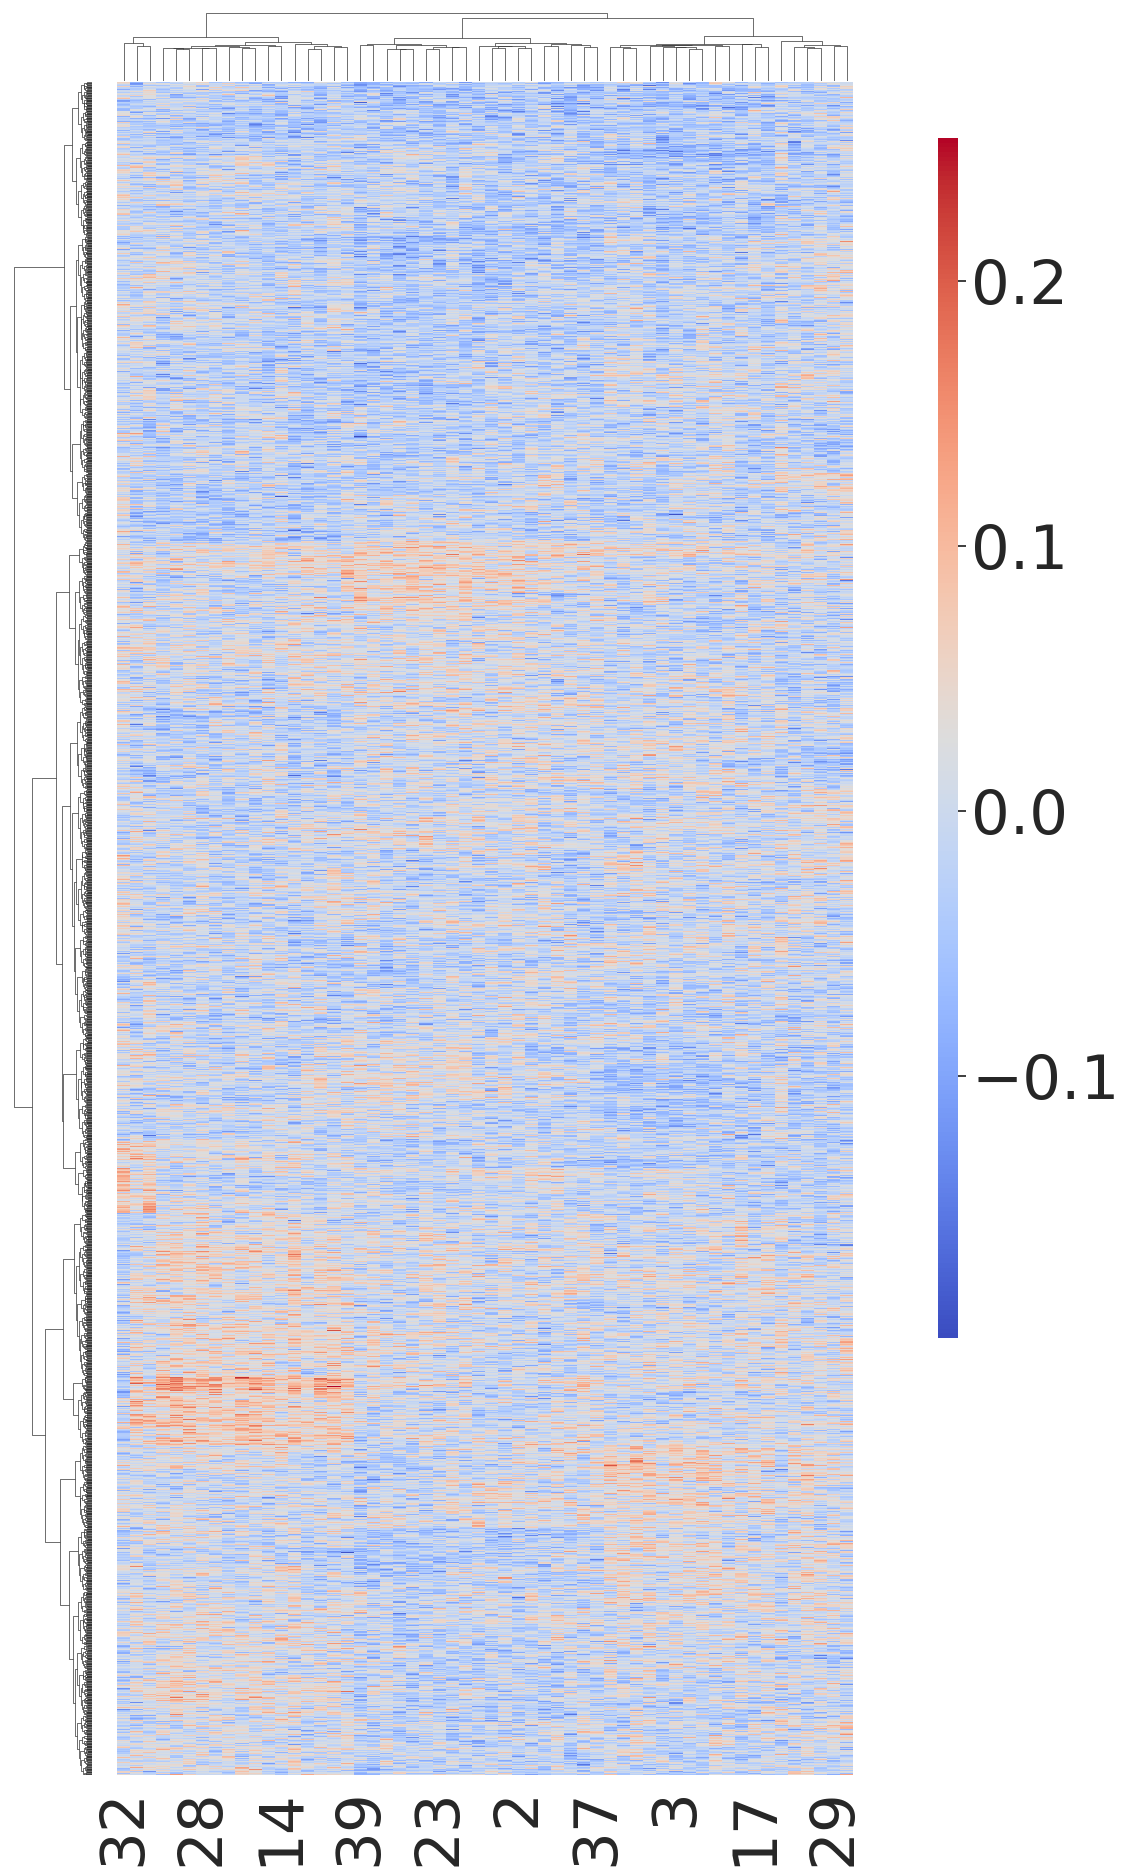

In [12]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
